# Aula 12 - Support Vector Machine (SVMs)

<img width=300 src="Aula 12/images/svm_intro.png" />


# Pontos Importantes:

<a href="https://www.sli.do/"> <img width=300 src="Aula 12/images/slido-logo.png"/> </a>



## 0. Me façam perguntas durante a aula no Sli.do:
    
    1. Link: https://sli.do ou  https://app.sli.do/event/clvhrpw0
    2. Código (#): aula12

## 1. O seu feedback é importante para nossa melhoria continua:

    1. 4 pessoas já comentaram.
    2. Link para submeter seu comentário: https://forms.gle/fyGZXbajM6rTo7Mv9



## 2. Usem o Slack da turma mais:

    1. Compartilhem novidades do universo da Ciência de Dados.
    2. Façam perguntas, sejam gerais ou específicas.
    3. Conheçam a turma e seus colegas, juntos essa jornada será mais fácil.
 

<img width=500 src="Aula 12/images/feedback.png" />


# Support Vector Machines | Máquina de vetores de suporte

* Este nome da medo, e a intuição deste método é bem mais simples do que imaginamos.
* É um método particularmente poderoso, flexível para classificação supervisionada.
* É para muitas pessoas um dos métodos mais díficieis de complexos, mas você vai entender.

# Objetivos da aula

1. Criar um *toy example* para vermos SVM em ação.
2. Kernel Trick.
3. O C da questão.
4. [Tentativa] Criar um classificador de faces humanas. 

## Importando bibliotecas necessárias

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Vamos usar seaborn hoje, para deixar nossos gráficos um pouco mais bonitos
import seaborn as sns; sns.set()
from ipywidgets import interact, fixed

## Toy Example: Dividir duas classes de bolinhas

* Na aula passada mostrei como criar 2 classes de bolinhas. Mas existe uma função no sklearn para isso.

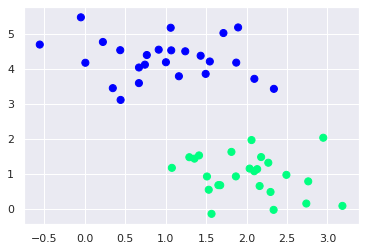

In [2]:
from sklearn.datasets.samples_generator import make_blobs

# Parametros:

X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.6)


# Plotando as bolinhas
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

# Matplolib tem varias paletas de cores interessante
# Cmap: ["autumn", "Wistia" ... ] https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html



# Como podemos traçar uma reta que divide as classes?

* Há infinitas retas que dividem estas duas classes perfeitamente.
* Dependendo da forma que você traçar estas retas, um dado novo, nunca visto receberá diferentes classificações.
* Devemos traçar uma reta que minimize a chance deste novo dado estar errado.


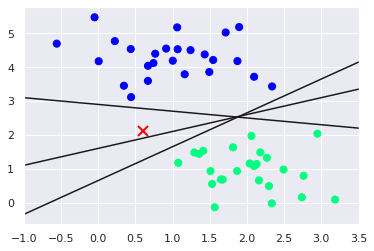

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

## SVMs maximizam a margem da reta

* A intuição é achar a reta que tem a margem maximizada entre as duas classes.
* Lembre-se a margem que é importante e teremos um parâmetro especifico para ela. (famoso C).
* Se a margem for muito grande, quer dizer que penalizamos mais os erros, mas podemos sofrer de overffiting.
* Se a margem for muito pequena, quer dizer que aceitamos penalizar menos os erros, mas pode resultar em um modelo fraco
* Achar o C correto é o X da questão.

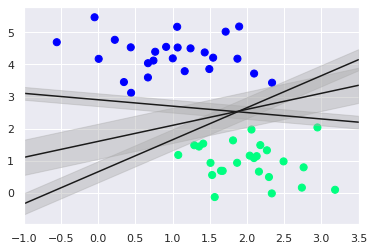

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

for angulo, constante, margem in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = angulo * xfit + constante
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - margem, yfit + margem, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

# Treinando um modelo SVM

* Vamos ver o resultado utilizando Scikit-Learn.
* Utilizaremos um Kernel Linear
* Utilizaremos um C bem largo inicialmente (depois discutiremos mais sobre C). 

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=10000000000)
model.fit(X, y)

SVC(C=10000000000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### Visualizando o modelo criado

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Cria um grid onde o modelo é avaliado
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

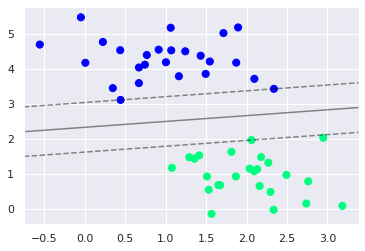

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(model);


### Observações

* Apenas os pontos proximo a margem são considerados. São eles que formam os "vetores de suporte" do nome SVM.
* Mesmo alterando os pontos "atrás" do vetor de suporte, o modelo não muda.

<img width=300 src="Aula 12/images/support_vectors.png" />

In [8]:
# Voce consegue acessar os pontos que formam os support vectors diretamente
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

### Exemplo: Mesma distribuição com diferentes quantidades de pontos

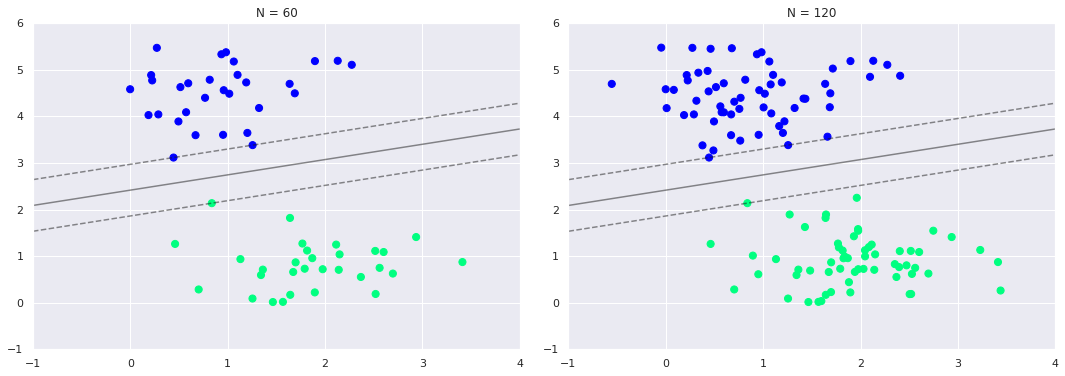

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

#### Observação:
* Mesmo dobrando a quantidade de pontos o modelo não mudou, e isso é positivo, pois mostra que o modelo é estável.

#  Kernel Trick

1. A ideia do SVM é bem poderosa,precisamos expandir para problemas não lineares.
2. Para isso utilizamos o "Kernel Trick". É um truque matemático que transforma um problema não linear em um problema linear utilizando uma função.
3. Exemplos de kernels: Polinomios, Sigmoid, Gaussian, Radial

<img src="Aula 12/images/kernel_trick.png" width=400 />

### Exemplo: Utilizando um Kernel  com a função Radial Basis (RBF)

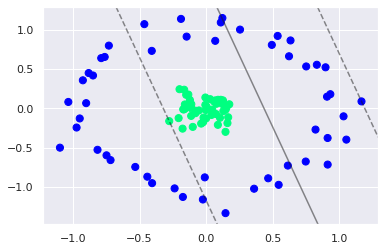

In [10]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1, random_state=0)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(clf, plot_support=False);

#### Não há como traçar uma reta que separe as duas classes de bolinhas 

In [11]:
#RBF: Radial Base Function
r = np.exp(-(X ** 2).sum(1))

### Visualizando Radial Base Function (RBF)

1. Quanto mais proximo do centro, maior o valor de R

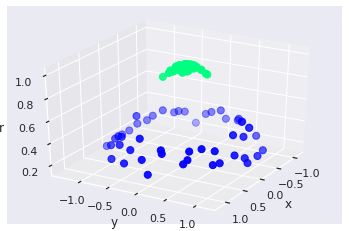

In [12]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='winter')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(30, 90), azip=(-180, 180),
         X=fixed(X), y=fixed(y));


#### Pergunta: Após transformar os dados para um espaço tridimensional, você conseguiria traçar uma reta que separa as classes?

### Treinando SVM utilizando um kernel RBF

In [13]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

/home/pedro/anaconda3/envs/pos-ds-ia-37/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

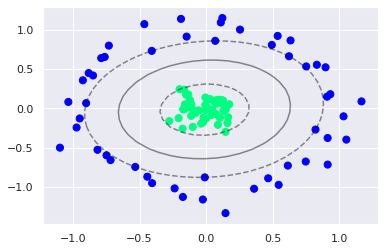

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

* Com o Kernel Trick o SVM consegue modelar conjunto de dados quepossuem decisões não lineares.
* Existe todo um arcabouço matemático por traz do Kernel Trick, que foge do escopo desta aula.

### Tornando as margens mais flexiveis (o C da Questão: )

1. Até agora vimos problemas bem simples, onde é fácil traçar uma reta que separa as classes.
2. Mas o que ocorre se o problema for um pouco mais difícil?


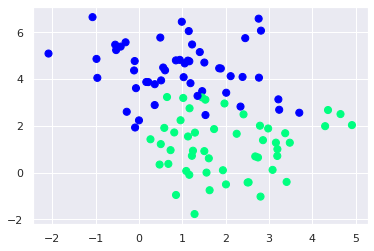

In [15]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter');

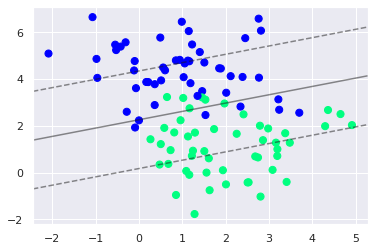

In [16]:
model = SVC(kernel='linear', C=0.01)
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(model);

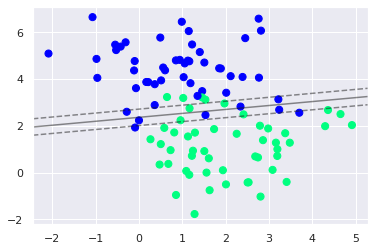

In [17]:
model = SVC(kernel='linear', C=1000000)
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plot_svc_decision_function(model);

1. Valores altos para C, temos uma margem menor. Demora mais para computar.
2. Valores baixos para C, a margem é menos rigorosa. Mais rápido para computar.

### Para encontrar o valor correto para C e qualquer outro hyper-parametro, precisamos de:
1. Cross-Validation
2. Grid-Search


## Como prometido: Projeto Classificação de Faces de VIPs

1. O conjunto de dados é disponibilizado pela biblioteca sklearn.
2. Total 5749 pessoas, mas utilizaremos apenas aquelas que tem no minimo 60 fotos.
3. V
As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [18]:
from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline


#Demora alguns minutos para rodar...
faces = fetch_lfw_people(min_faces_per_person=60)

## Uma imagem é formada por 62x47 pixels
1. Cada pixel é uma feature.
2. Cada pixel é um valor tem um valor entre 0 (preto) e 255 (branco)

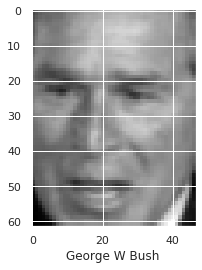

In [19]:
n_components = 150
pca = RandomizedPCA(n_components=n_components, whiten=True, random_state=42)
fig, ax = plt.subplots(1,1)
ax.imshow(faces.data[0].reshape(62, 47), cmap='gray')
ax.set_xlabel(faces.target_names[faces.target[0]])
plt.show()

### Utilizando PCA eu consigo diminuir as dimensões da minha imagem

Principal Components Shape :  (639, 150)


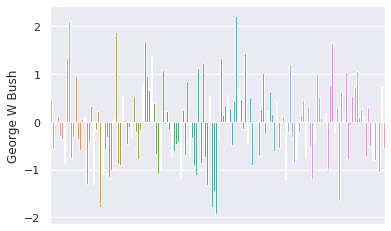

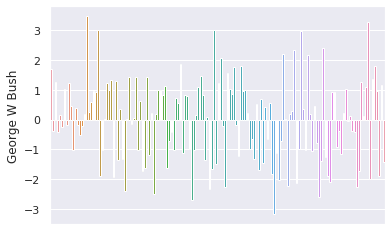

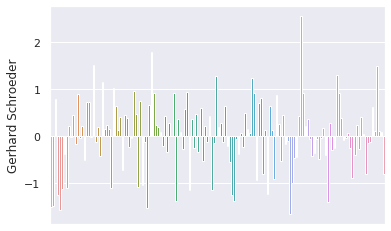

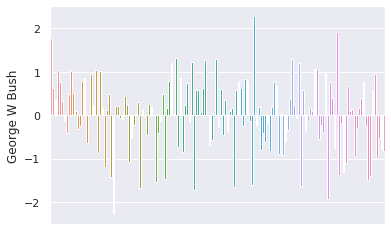

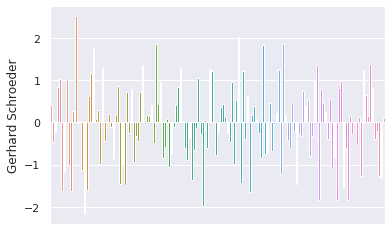

In [20]:
principal_components = pca.fit_transform(faces.data)
print("Principal Components Shape : ", principal_components.shape)
for i in range(5):
    values = principal_components[i]
    ax = sns.barplot(x = [*range(0,n_components)], y =values)
    ax.set_ylabel(faces.target_names[faces.target[i]]) 
    ax.set_xticks([])
    plt.show()
    


### O PCA permite inverter a transformação para a dimensão original

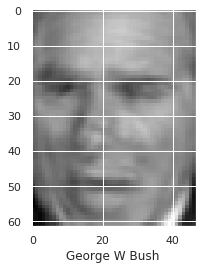

In [21]:
newFaces = pca.inverse_transform(principal_components)

fig, ax = plt.subplots(1,1)
ax.imshow(newFaces[0].reshape(62, 47), cmap='gray')
ax.set_xlabel(faces.target_names[faces.target[0]])
plt.show()


### Vamos ver quais são as pessoas que estamos analisando

Classes: [0 1]


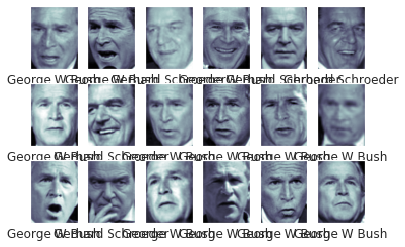

In [22]:
fig, ax = plt.subplots(3, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])
print("Classes:", np.unique(faces.target))

### Definindo classificador SVM
1. Parametros foram escolhidos através de gridsearch

In [23]:
svc = SVC(kernel='rbf', class_weight='balanced', decision_function_shape='ovr', C = 10, gamma = 0.1)
model = make_pipeline(pca, svc)

### Dividindo os dados para treino e teste

In [24]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

### Treinando Modelo

In [25]:
model.fit(Xtrain, ytrain)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=150,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('svc',
                 SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.1,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

### Agora vamos classificar imagens não vista pelo classificador

In [26]:
yfit = model.predict(Xtest)
print("Test: ", Xtest.shape)
yfit

Test:  (160, 2914)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

### Qualidade do nosos classificador

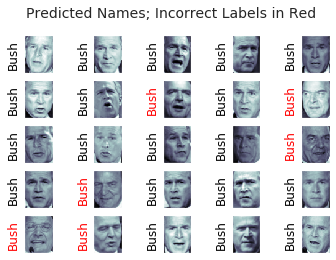

In [27]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1], color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

### Outras métricas do nosso classificador

In [28]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

precision    recall  f1-score   support

    George W Bush       0.86      1.00      0.93       138
Gerhard Schroeder       0.00      0.00      0.00        22

         accuracy                           0.86       160
        macro avg       0.43      0.50      0.46       160
     weighted avg       0.74      0.86      0.80       160

/home/pedro/anaconda3/envs/pos-ds-ia-37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Matrix de confusão do nosso classificador

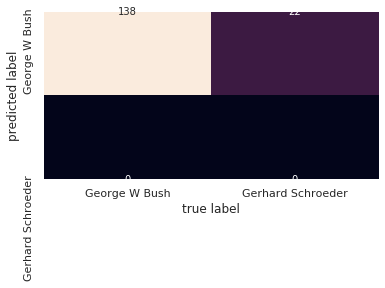

In [29]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Modificador e traduzido por: Matheus Araujo

### Referencias e autor original deste jupyter notebook:
<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

[Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) e [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook). 
